In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Small Molecule Property Optimization - QED

>Small molecule QED optimization

## QED Optimization

This notebook shows how to optimize a generative model with respect to [QED](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3524573/) score. This is a standard benchmark in many generative design papers

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `LSTM_LM_Small_ZINC_NC` - a LSTM-based language model pretrained on part of the ZINC database without chirality. Training without chirality prevents a form of mode collapse where the model converges to generating different isomers of the same compound.

Whether or not to use a model trained with or without chirality depends on the reward function you are trying to optimize. You should use a model with chirality if your reward function handles chirality in a meaningful way. Specically this means your reward function should give different scores to different isomers. This difference should relate to a real aspect of the propety predicted (ie affinity of different isomers) rather than being a spurious feature learned by the model (this happens surprisingly often).

QED score isn't impacted by chirality, so using a non-chiral model makes sense

In [ ]:
agent = LSTM_LM_Small_ZINC_NC(drop_scale=0.3, opt_kwargs={'lr':5e-5})

## Template

Here we create our template.

We set the following hard filters:
- `ValidityFilter`: screens for vaid compounds
- `SingleCompoundFilter`: screens for single compounds

We set the following soft filters:
- `QEDFilter`: evaluates the QED score of a compound. By passing `score=PassThroughScore()`, this filter simply returns the QED score

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     ],
                    [QEDFilter(None, None, score=PassThroughScore())], 
                    fail_score=-1.)

template_cb = TemplateCallback(template, prefilter=True)

## Reward

We are only optimizing towards QED score, which is contained in our template. For this reason, we don't have any additional score terms

## Loss Function

We will use the `PPO` policy gradient algorithm

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

## Samplers

We set up the following samplers:
- `sampler1`: samples from the main model
- `sampler2`: samples from the baseline model
- `sampler3`: samples high scoring compounds from the log

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0., gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)

samplers = [sampler1, sampler2, sampler3]

## Other Callbacks

We add the following callbacks:
- `supervised_cb`: every 200 batches, this callback grabs the top 3% of samples from the log and runs supervised training with these samples
- `live_max`: prints the maximum score from `sampler1` each batch
- `live_p90`: prints the top 10% score from `sampler1` each batch

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[], losses=[loss],
                 cbs=cbs)

## Train

In [ ]:
# set_global_pool(min(10, os.cpu_count()))

In [ ]:
env.fit(200, 90, 2000, 50)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,PPO,rewards_live_p90,rewards_live_max
0,0.731,0.731,1.000,1.000,200,0.731,1.000,0.115,0.853,0.935
50,0.738,0.738,0.965,1.000,200,0.738,1.000,-0.026,0.872,0.934
100,0.760,0.760,0.920,1.000,200,0.760,1.000,-0.045,0.887,0.939
150,0.760,0.760,0.945,1.000,200,0.760,1.000,-0.063,0.890,0.942
200,0.771,0.771,0.970,1.000,200,0.771,1.000,-0.058,0.875,0.915
250,0.773,0.773,0.930,1.000,200,0.773,1.000,0.075,0.904,0.941
300,0.778,0.778,0.955,1.000,200,0.778,1.000,-0.045,0.901,0.943
350,0.793,0.793,0.950,1.000,200,0.793,1.000,-0.051,0.912,0.940
400,0.800,0.800,0.975,1.000,200,0.800,1.000,-0.038,0.911,0.938
450,0.815,0.815,0.965,1.000,200,0.815,1.000,-0.040,0.911,0.946


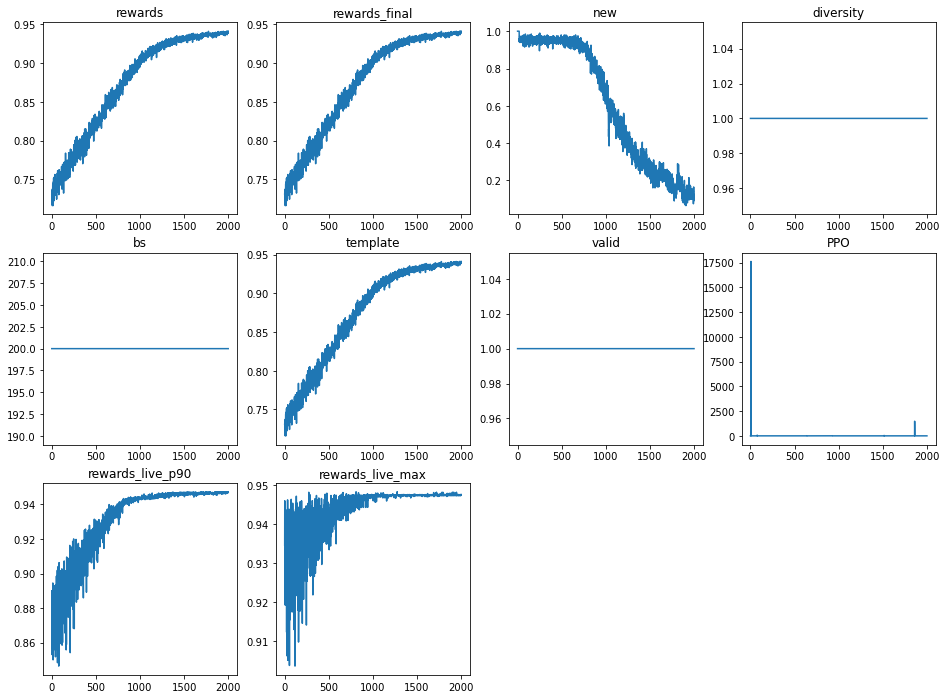

In [ ]:
env.log.plot_metrics()

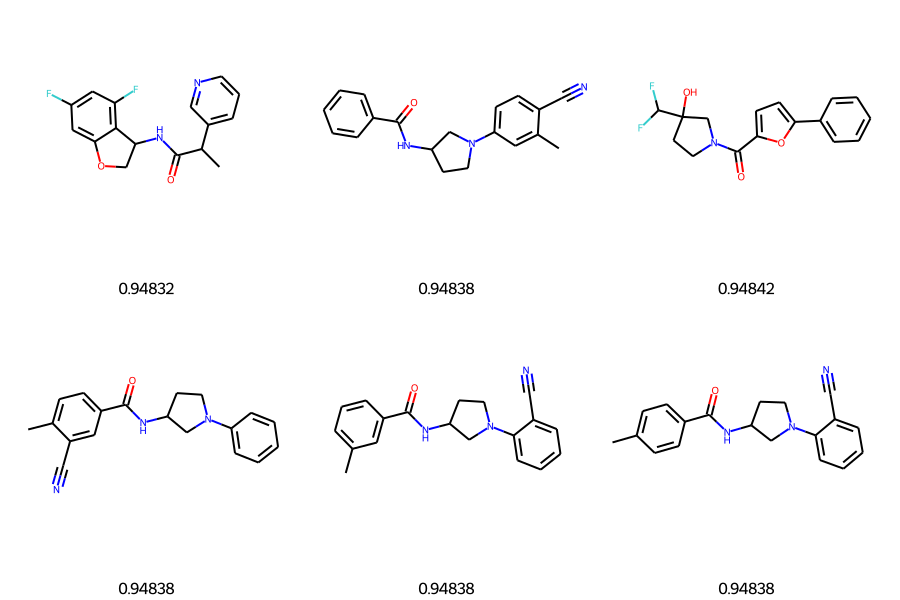

In [ ]:
subset = env.log.df[env.log.df.template>.9483]
draw_mols(to_mols(subset.samples.values), legends=[f"{i:.5f}" for i in subset.rewards.values])